# HW01 Results

In [143]:
# Import required libraries for excecution
from gensim import corpora
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scripts.metrics import Metrics
metrics = Metrics()

## Comparison of BS and BSII

In [144]:
# Load each Binary Search result file and concatenate them all in one dataframe
tag_df = pd.read_csv('./data/relevance-judgments.tsv', sep='\t', header=None, index_col = 0)
tag_df.index.name = 'query'
tag_df.columns = ['tag']
BS_and = pd.read_csv('./results/BS-queries_results_and.tsv', sep='\t', header=None, index_col = 0)
BS_and.index.name = 'query'
BS_and.columns = ['BS_and']
BS_or = pd.read_csv('./results/BS-queries_results_or.tsv', sep='\t', header=None, index_col = 0)
BS_or.index.name = 'query'
BS_or.columns = ['BS_or']
BS_II_and = pd.read_csv('./results/BSII-AND-queries-results.tsv', sep='\t', header=None, index_col = 0)
BS_II_and.index.name = 'query'
BS_II_and.columns = ['BS_II_and']
BS_II_or = pd.read_csv('./results/BSII-OR-queries-results.tsv', sep='\t', header=None, index_col = 0)
BS_II_or.index.name = 'query'
BS_II_or.columns = ['BS_II_or']
BS_df = pd.concat([BS_and, BS_or, BS_II_and, BS_II_or], axis = 1)
BS_df.fillna('', inplace = True)

In [145]:
# Usefull functions
def convert_to_list(tag):
    """ Recieves results string containing documents and converts it to a list.
    
    Args:
        tag (str): String with docuemnts 'dXXX,dYYY'
    
    Returns:
        list: Numbers of the docuemnts given as argument
    """
    tag = tag.replace(',','').split('d')[1:]
    tag_list = []
    for i in tag:
        tag_list.append(int(i))
    return tag_list


def convert_to_evaluation(pred, tag):
    """ Returns list with 1 in the relevant documents and 0 in the irrelevant ones according to tags
    
    Args:
        pred (list): Prediction to be compared with tag
        tag (list): List of relevant documents
        
    Returns:
        list: Binary relevant list
    
    """
    evaluation = pred.copy()
    for i, doc in enumerate(pred):
        if doc in tag:
            evaluation[i] = 1
        else:
            evaluation[i] = 0
    return evaluation

def convert_to_evaluation_relevance(pred, tag, relevance):
    """ Returns list with 1 in the relevant documents and 0 in the irrelevant ones according to tags
    
    Args:
        pred (list): Prediction to be compared with tag
        tag (list): List of relevant documents
        relevance (list): Relevance of docs in tag
        
    Returns:
        list: Binary relevant list
    
    """
    evaluation = pred.copy()
    for i, doc in enumerate(pred):
        for j, t in enumerate(tag):
            if doc == t:
                evaluation[i] = relevance[j]
                break
            else:
                evaluation[i] = 0
                
    return evaluation

def read_tag(param):
    """ Parses a tag to keep only doc Ids
    
    Args:
        param (<class 'pandas.core.series.Series'>): Series from pandas.DataFrame with tag information
    
    
    Returns:
        list: Numbers of relevant documents 
    """
    tag = param.tag
    tag = tag.split('d')[1:]
    tag_list = []
    for i in tag:
        tag_list.append(int(i[0:3]))
    return tag_list

def read_tag_relevance(param):
    """ Parses a tag to keep only relevance of doc
    
    Args:
        param (<class 'pandas.core.series.Series'>): Series from pandas.DataFrame with tag information
    
    
    Returns:
        list: Numbers of relevant documents 
    """
    tag = param.tag
    tag = tag.split(':')[1:]
    tag_list = []
    for i in tag:
        tag_list.append(int(i[0]))
    return tag_list

def get_f1_score(param, strategy):
    """ Calculates f1-score
    
    Args:
        param (<class 'pandas.core.series.Series'>): Series from pandas.DataFrame with P and R information
        strategy (str): Strategy to calculate f1-score
    
    Returns:
        float: f1-score for given case
    """
    if strategy == 'BS_and':
        precision = param.precision.BS_and
        recall = param.recall.BS_and
    if strategy == 'BS_or':
        precision = param.precision.BS_or
        recall = param.recall.BS_or
    if strategy == 'BS_II_and':
        precision = param.precision.BS_II_and
        recall = param.recall.BS_II_and
    if strategy == 'BS_II_or':
        precision = param.precision.BS_II_or
        recall = param.recall.BS_II_or
    if precision + recall > 0:
        return 2*(precision*recall)/(precision+recall)
    else:
        return 0

In [146]:
# Apply relevant functions and add tag to main dataframe
BS_df = BS_df.applymap(convert_to_list)

aux_df = tag_df.copy()

tag_df['tag'] = tag_df.apply(read_tag, axis=1)
tag_df['relevance'] = aux_df.apply(read_tag_relevance, axis=1)

BS_df = pd.concat([BS_df, tag_df], axis=1)

In [147]:
# Strategy vector
strategies = ['BS_and', 'BS_or', 'BS_II_and', 'BS_II_or']
# Creates dataframe with precision for each query and each strategy
data = {}
for strategy in strategies:
    # Loop over strategy vector
    precision = []
    for query in BS_df.index:
        try:
            # Use metrics class to calculate precision
            precision.append(metrics.precision(
                convert_to_evaluation(BS_df.loc[query, strategy], BS_df.loc[query, 'tag'])))
        except:
            # Exception for empty query
            precision.append(0)
    # Dictionary to append to data for dataframe
    result = {strategy: precision}
    # Update dictionary
    data.update(result)
# Create data frame
precision_df = pd.DataFrame(data = data)

In [148]:
# Creates dataframe with average_precision for each query and each strategy
data = {}
for strategy in strategies:
    # Loop over strategy vector
    average_precision = []
    for query in BS_df.index:
        try:
            # Use metrics class to calculate average precision
            average_precision.append(metrics.average_precision(
                convert_to_evaluation(BS_df.loc[query, strategy], BS_df.loc[query, 'tag'])))
        except:
            # Exception for empty query
            average_precision.append(0)
    # Dictionary to append to data for dataframe
    result = {strategy: average_precision}
    # Update dictionary
    data.update(result)
# Create data frame
average_precision_df = pd.DataFrame(data = data)

In [149]:
# Creates dataframe with recall for each query and each strategy
data = {}
for strategy in strategies:
    # Loop over strategy vector
    recall = []
    for query in BS_df.index:
        try:
            # Use metrics to calculate recal at k
            recall.append(
                metrics.recall_at_k(convert_to_evaluation(BS_df.loc[query, strategy], 
                BS_df.loc[query, 'tag']), len(BS_df.loc[query, 'tag']), len(BS_df.loc[query, strategy])))
        except:
            # Exception for empty query
            recall.append(0)
    # Dictionary to append for dataframe
    result = {strategy: recall}
    # Update dictionary
    data.update(result)
# Create dateframe
recall_df = pd.DataFrame(data = data)
# Concatenate 3 metrics dataframes
metrics_df = pd.concat([precision_df, average_precision_df, recall_df],
                       keys=['precision', 'average precision', 'recall'], axis = 1)

In [150]:
# Apply fucntion to metrics dataframe to get f1-score
metrics_df['f1-score','BS_and'] = metrics_df.apply(get_f1_score, axis=1, args=['BS_and'])
metrics_df['f1-score','BS_or'] = metrics_df.apply(get_f1_score, axis=1, args=['BS_or'])
metrics_df['f1-score','BS_II_and'] = metrics_df.apply(get_f1_score, axis=1, args=['BS_II_and'])
metrics_df['f1-score','BS_II_or'] = metrics_df.apply(get_f1_score, axis=1, args=['BS_II_or'])

In [151]:
metrics_df.mean()

precision          BS_and       0.591410
                   BS_or        0.113620
                   BS_II_and    0.285220
                   BS_II_or     0.113052
average precision  BS_and       0.653010
                   BS_or        0.189985
                   BS_II_and    0.336383
                   BS_II_or     0.191064
recall             BS_and       0.245421
                   BS_or        0.919184
                   BS_II_and    0.148163
                   BS_II_or     0.903401
f1-score           BS_and       0.289852
                   BS_or        0.164839
                   BS_II_and    0.153151
                   BS_II_or     0.163530
dtype: float64

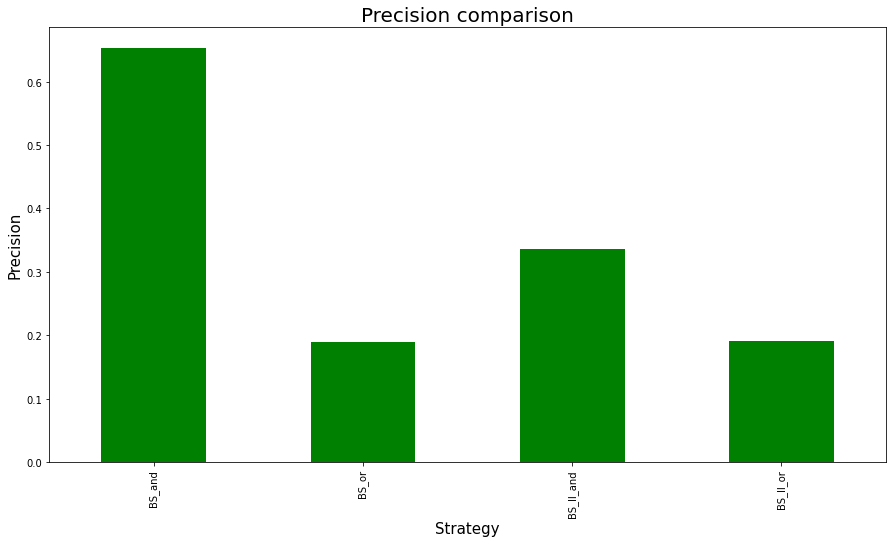

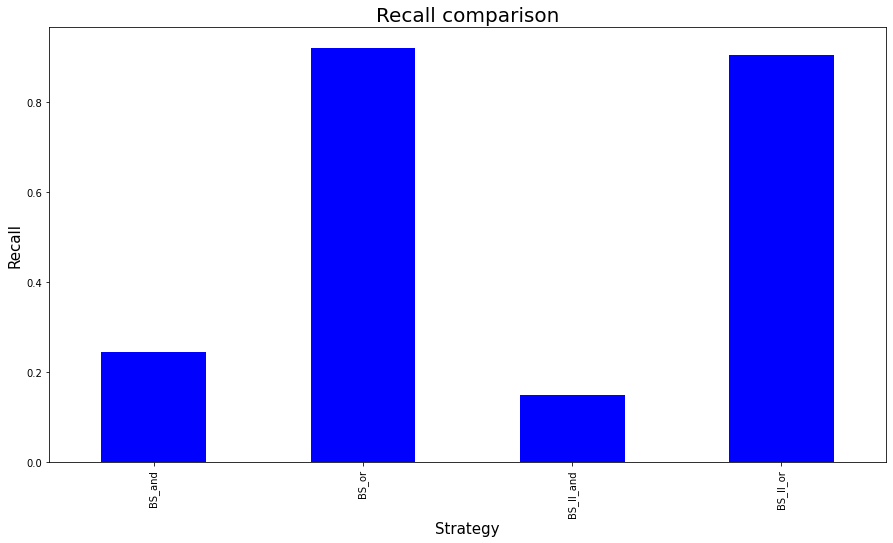

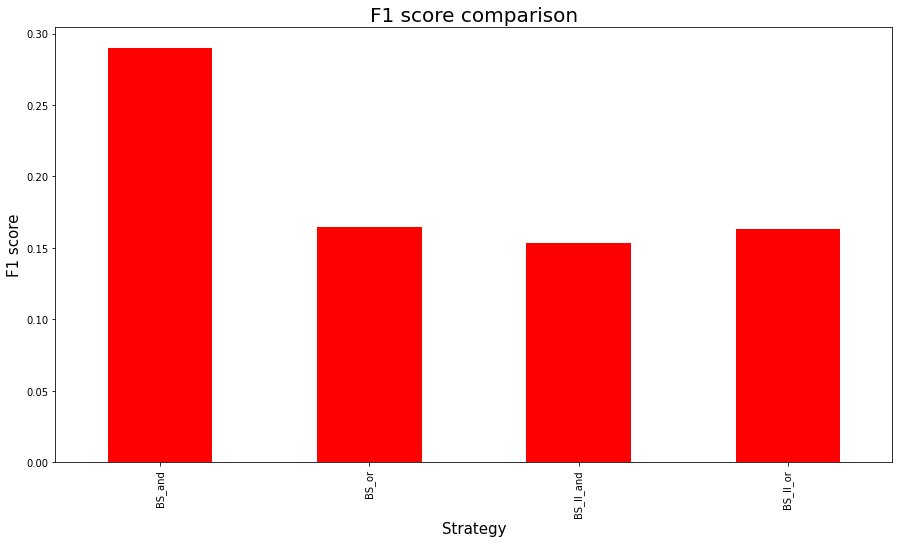

In [152]:
plt.figure()
metrics_df.loc[:,'average precision'].mean().plot.bar(figsize=(15,8), color=('green'))
plt.title('Precision comparison', fontsize=20)
plt.xlabel('Strategy', fontsize=15)
plt.ylabel('Precision', fontsize=15)
plt.savefig('./results/images/BS_precision_comparison.png')
plt.figure()
metrics_df.loc[:,'recall'].mean().plot.bar(figsize=(15,8), color=('blue'))
plt.title('Recall comparison', fontsize=20)
plt.xlabel('Strategy', fontsize=15)
plt.ylabel('Recall', fontsize=15)
plt.savefig('./results/images/BS_recall_comparison.png')
plt.figure()
metrics_df.loc[:,'f1-score'].mean().plot.bar(figsize=(15,8), color=('red'))
plt.title('F1 score comparison', fontsize=20)
plt.xlabel('Strategy', fontsize=15)
plt.ylabel('F1 score', fontsize=15)
plt.savefig('./results/images/BS_f1_comparison.png')

## Comparison of RRI, RRDV and Gensim

In [153]:
# Load each Binary Search result file and concatenate them all in one dataframe
RRI_df = pd.read_csv('./results/RRI-queries_results.tsv', sep='\t', header=None, index_col = 0)
RRI_df.index.name = 'query'
RRI_df.columns = ['RRI']

RRDV_df = pd.read_csv('./results/RRDV-queries_results.tsv', sep='\t', header=None, index_col = 0)
RRDV_df.index.name = 'query'
RRDV_df.columns = ['RRDV']

Gensim_df = pd.read_csv('./results/GENSIM-queries_results.tsv', sep='\t', header=None, index_col = 0)
Gensim_df.index.name = 'query'
Gensim_df.columns = ['Gensim']

Ranked_df = pd.concat([RRI_df, RRDV_df, Gensim_df], axis = 1)

In [154]:

# Apply relevant functions and add tag to main dataframe
Ranked_df = Ranked_df.applymap(convert_to_list)
Ranked_df = pd.concat([Ranked_df, tag_df], axis=1)

In [155]:
# P@M

# Strategy vector
strategies = ['RRI', 'RRDV', 'Gensim']

# Creates dataframe with precision for each query and each strategy
data = {}
for strategy in strategies:
    # Loop over strategy vector
    precision = []
    for query in Ranked_df.index:
        try:
            # Use metrics class to calculate precision
            precision.append(metrics.precision_at_k(
                convert_to_evaluation(Ranked_df.loc[query, strategy], 
                                      Ranked_df.loc[query, 'tag']), len(Ranked_df.loc[query, 'tag'])))
        except:
            # Exception for empty query
            precision.append(0)
    # Dictionary to append to data for dataframe
    result = {strategy: precision}
    # Update dictionary
    data.update(result)

# Create data frame
ranked_precision_df = pd.DataFrame(data = data)

In [156]:
# R@M

# Creates dataframe with precision for each query and each strategy
data = {}
for strategy in strategies:
    # Loop over strategy vector
    recall = []
    for query in Ranked_df.index:
        try:
            # Use metrics class to calculate precision
            recall.append(metrics.recall_at_k(
                convert_to_evaluation(Ranked_df.loc[query, strategy], 
                                      Ranked_df.loc[query, 'tag']), len(Ranked_df.loc[query, 'tag']), len(Ranked_df.loc[query, 'tag'])))
        except:
            # Exception for empty query
            recall.append(0)
    # Dictionary to append to data for dataframe
    result = {strategy: recall}
    # Update dictionary
    data.update(result)

# Create data frame
ranked_recall_df = pd.DataFrame(data = data)

In [157]:
# Average Precision

# Creates dataframe with average_precision for each query and each strategy
data = {}
for strategy in strategies:
    # Loop over strategy vector
    average_precision = []
    for query in Ranked_df.index:
        try:
            # Use metrics class to calculate average precision
            average_precision.append(metrics.average_precision(
                convert_to_evaluation(Ranked_df.loc[query, strategy], Ranked_df.loc[query, 'tag'])))
        except:
            # Exception for empty query
            average_precision.append(0)
    # Dictionary to append to data for dataframe
    result = {strategy: average_precision}
    # Update dictionary
    data.update(result)
    
# Create data frame
ranked_average_precision_df = pd.DataFrame(data = data)

In [158]:
# NDGC@M

# Creates dataframe with average_precision for each query and each strategy
data = {}
for strategy in strategies:
    # Loop over strategy vector
    ndcg = []
    for query in Ranked_df.index:
        try:
            # Use metrics class to calculate average precision
            ndcg.append(metrics.NDCG(
                convert_to_evaluation_relevance(Ranked_df.loc[query, strategy], 
                                                Ranked_df.loc[query, 'tag'], 
                                                Ranked_df.loc[query, 'relevance']), len(Ranked_df.loc[query, 'tag'])))
        except:
            # Exception for empty query
            ndcg.append(0)
    # Dictionary to append to data for dataframe
    result = {strategy: ndcg}
    # Update dictionary
    data.update(result)
    
# Create data frame
ranked_ndcg_df = pd.DataFrame(data = data)

In [159]:
# Concatenate 4 metrics dataframes
ranked_metrics_df = pd.concat([ranked_precision_df, ranked_recall_df, ranked_ndcg_df, ranked_average_precision_df],
                       keys=['P@M', 'R@M', 'NDCG@M','MAP'], axis = 1)

# Mean
print("MEAN: ")
ranked_metrics_df.mean()

MEAN: 


P@M     RRI       0.628703
        RRDV      0.592329
        Gensim    0.595526
R@M     RRI       0.614418
        RRDV      0.578044
        Gensim    0.581240
NDCG@M  RRI       0.731693
        RRDV      0.696736
        Gensim    0.661810
MAP     RRI       0.734017
        RRDV      0.697172
        Gensim    0.659150
dtype: float64

<AxesSubplot:>

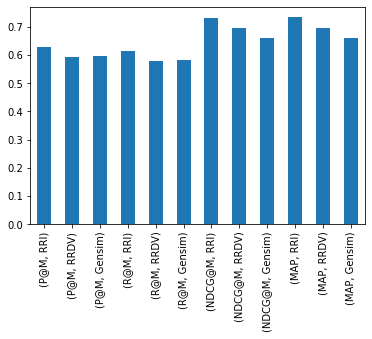

In [160]:
ranked_metrics_df.mean().plot.bar()

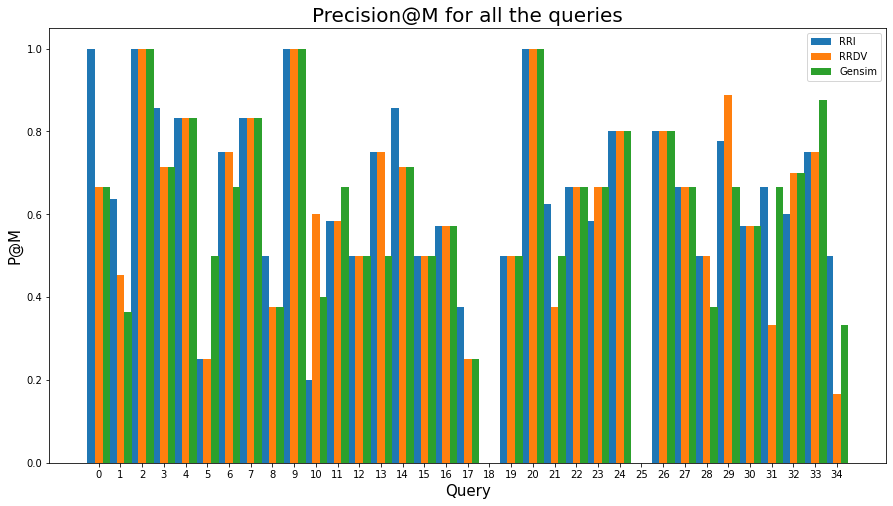

In [161]:
# Retrieve P@M values for each strategies 
RRI_Precision = ranked_metrics_df['P@M']['RRI'].values
RRDV_Precision = ranked_metrics_df['P@M']['RRDV'].values
Gensim_Precision = ranked_metrics_df['P@M']['Gensim'].values

# Plot
x = np.arange(35)
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15,8))
rects1 = ax.bar(x - width, RRI_Precision, width, label='RRI')
rects2 = ax.bar(x, RRDV_Precision, width, label='RRDV')
rects2 = ax.bar(x + width, Gensim_Precision, width, label='Gensim')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Precision@M for all the queries', fontsize=20)
ax.set_ylabel('P@M', fontsize=15)
ax.set_xlabel('Query', fontsize=15)
ax.set_xticks(x)
ax.legend()
plt.savefig('./results/images/P@M_Ranked.png')
plt.show()

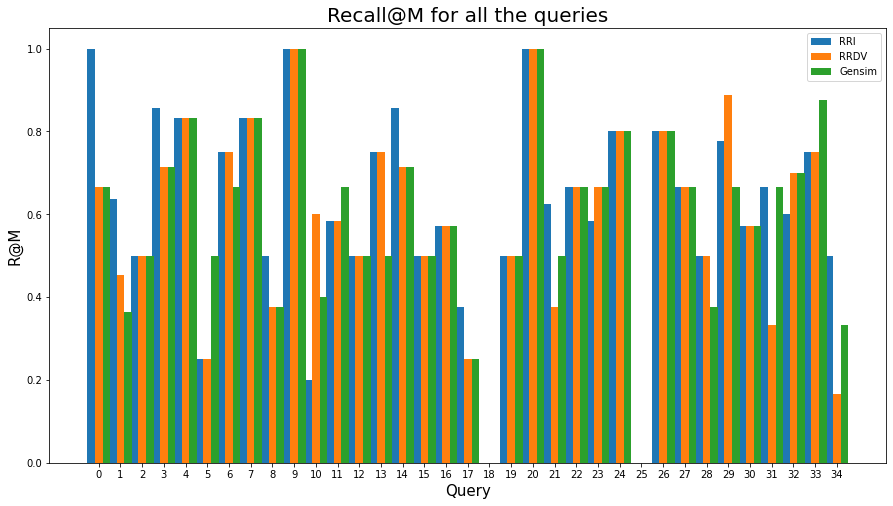

In [162]:
# Retrieve R@M values for each strategies 
RRI_Precision = ranked_metrics_df['R@M']['RRI'].values
RRDV_Precision = ranked_metrics_df['R@M']['RRDV'].values
Gensim_Precision = ranked_metrics_df['R@M']['Gensim'].values

# Plot
x = np.arange(35)
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15,8))
rects1 = ax.bar(x - width, RRI_Precision, width, label='RRI')
rects2 = ax.bar(x, RRDV_Precision, width, label='RRDV')
rects2 = ax.bar(x + width, Gensim_Precision, width, label='Gensim')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Recall@M for all the queries', fontsize=20)
ax.set_ylabel('R@M', fontsize=15)
ax.set_xlabel('Query', fontsize=15)
ax.set_xticks(x)
ax.legend()
plt.savefig('./results/images/R@M_Ranked.png')
plt.show()

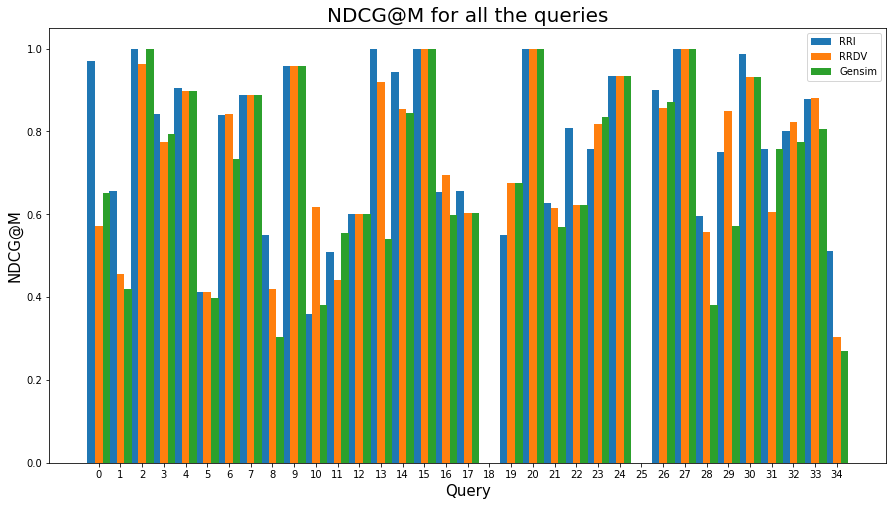

In [163]:
# Retrieve NDCG@M values for each strategies 
RRI_Precision = ranked_metrics_df['NDCG@M']['RRI'].values
RRDV_Precision = ranked_metrics_df['NDCG@M']['RRDV'].values
Gensim_Precision = ranked_metrics_df['NDCG@M']['Gensim'].values

# Plot
x = np.arange(35)
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15,8))
rects1 = ax.bar(x - width, RRI_Precision, width, label='RRI')
rects2 = ax.bar(x, RRDV_Precision, width, label='RRDV')
rects2 = ax.bar(x + width, Gensim_Precision, width, label='Gensim')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('NDCG@M for all the queries', fontsize=20)
ax.set_ylabel('NDCG@M', fontsize=15)
ax.set_xlabel('Query', fontsize=15)
ax.set_xticks(x)
ax.legend()
plt.savefig('./results/images/NDCG@M_Ranked.png')
plt.show()